In [1]:
from jax import config

config.update("jax_enable_x64", True)

import os
# os.environ['CUDA_VISIBLE_DEVICES'] = ""
os.environ['CUDA_VISIBLE_DEVICES'] = "0,1,2"

import numpy as np
import jax.numpy as jnp
import so3 

from jax import jit, device_put, pmap
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

from s2fft import utils
from s2fft.wigner import samples
from s2fft.jax_transforms import wigner
from s2fft.wigner.price_mcewen import generate_precomputes_wigner

import warnings
warnings.simplefilter("ignore")

gpu


In [2]:
# Define parameters of transform
L_approx = 2048
L = 3*int(L_approx/3)
N = 3
spin = 0
reality = False
params = so3.create_parameter_dict(L=L, N=N, L0=0, sampling_scheme_str="SO3_SAMPLING_MW", reality=False)


# Define iso-latitudinal sampling scheme
sampling = "mw"

# Generate a random signal
rng = np.random.default_rng(1351235151)

# Generate some bandlimit Wigner coefficients
f_shape = samples.f_shape(L, N, sampling)
f = np.random.randn(f_shape[0], f_shape[1], f_shape[2]) + 1j * np.random.randn(f_shape[0], f_shape[1], f_shape[2])
flmn_1D = so3.forward(f.flatten('C'), params)
flmn = samples.flmn_1d_to_3d(flmn_1D, L, N)

In [3]:
f_so3 = so3.inverse(flmn_1D, params)
%timeit so3.inverse(flmn_1D, params)

2min 29s ± 274 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [4]:
# Generate O(NL^2) memory precompute
precomps = generate_precomputes_wigner(L, N, sampling)

flmn_jax = device_put(flmn)
f_jax = wigner.inverse_jax(flmn_jax, L, N, None, sampling, reality, precomps, spmd=False)
%timeit wigner.inverse_jax(flmn_jax, L, N, None, sampling, reality, precomps, spmd=False)

26.3 s ± 4.39 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [5]:
# Generate O(NL^2) memory precompute
precomps = generate_precomputes_wigner(L, N, sampling)

flmn_jax = device_put(flmn)
f_jax_spmd = wigner.inverse_jax(flmn_jax, L, N, None, sampling, reality, precomps, spmd=True)
%timeit wigner.inverse_jax(flmn_jax, L, N, None, sampling, reality, precomps, spmd=True)

9.83 s ± 330 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


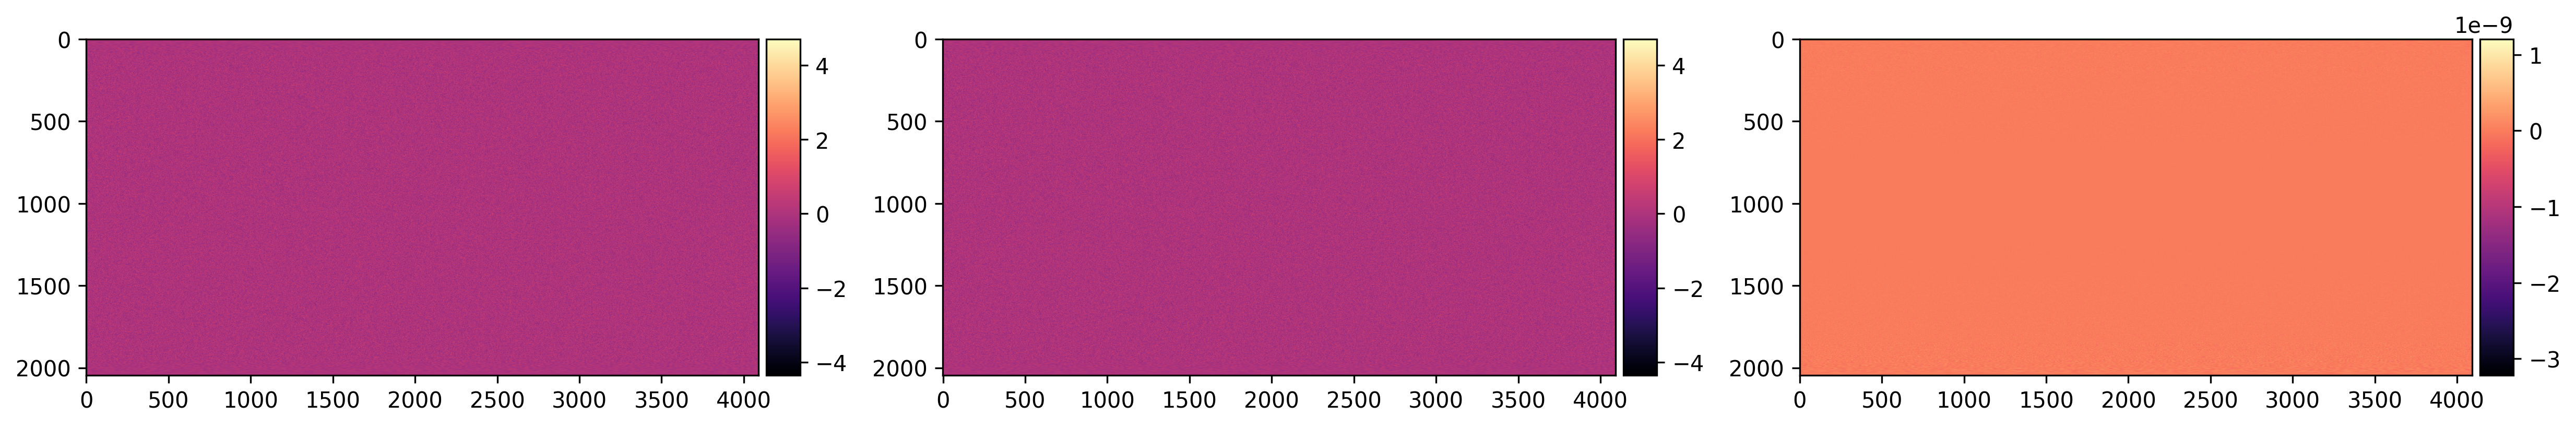

In [6]:
from matplotlib import pyplot as plt 
from mpl_toolkits.axes_grid1 import make_axes_locatable

f_so3 = f_so3.reshape(2*N-1, L, 2*L-1)

mx, mn = np.nanmax(np.real(f_so3[N-1])),np.nanmin(np.real(f_so3[N-1]))
plt.rcParams["figure.figsize"] = (20,3)
plt.rcParams["figure.dpi"] = 300

fig, (ax1,ax2,ax3) = plt.subplots(1,3)
im1 = ax1.imshow(np.real(f_so3[N-1]), vmax=mx, vmin=mn, cmap='magma')
im2 = ax2.imshow(np.real(f_jax[N-1]), vmax=mx, vmin=mn, cmap='magma')
im3 = ax3.imshow(np.real(f_so3[N-1])-np.real(f_jax[N-1]), cmap='magma')

divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical')

divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax, orientation='vertical')

divider = make_axes_locatable(ax3)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im3, cax=cax, orientation='vertical')

plt.show()